<a href="https://colab.research.google.com/github/SamuelEiler/wgan/blob/main/G_lstm_D_conv1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


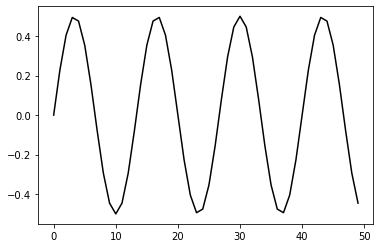

epoch/iteration 0/0  lossD: 1.3895  lossG: 0.6991
epoch/iteration 0/100  lossD: 1.3821  lossG: 0.6911
epoch/iteration 0/200  lossD: 1.3812  lossG: 0.7002
epoch/iteration 0/300  lossD: 1.3817  lossG: 0.6944
epoch/iteration 1/0  lossD: 1.3770  lossG: 0.6911
epoch/iteration 1/100  lossD: 1.3856  lossG: 0.6740
epoch/iteration 1/200  lossD: 1.3840  lossG: 0.6944
epoch/iteration 1/300  lossD: 1.3831  lossG: 0.6906
epoch/iteration 2/0  lossD: 1.3875  lossG: 0.6944
epoch/iteration 2/100  lossD: 1.3852  lossG: 0.6929
epoch/iteration 2/200  lossD: 1.3921  lossG: 0.6966
epoch/iteration 2/300  lossD: 1.3865  lossG: 0.6993


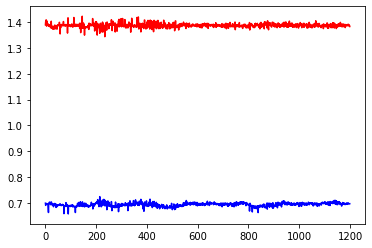

In [53]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import savetxt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from datetime import datetime
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMGenerator(nn.Module):
    def __init__(self, batch_size, in_seq_len, in_features, out_dim, n_layers, hidden_dim):
        super(LSTMGenerator, self).__init__()
        self.batch_size = batch_size
        self.in_seq_len = in_seq_len
        self.in_features = in_features  
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=in_features, hidden_size=hidden_dim, num_layers=n_layers, bias=True, batch_first=True, dropout=0.2, bidirectional=False)
        self.linear = nn.Linear(self.hidden_dim * self.in_seq_len, 1)  #[32, 3800] 200 * 19 = 

    def forward(self, input):   #[batch_size, seq_len, input_size]
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim, requires_grad=True).to(device)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim, requires_grad=True).to(device)
        lstm_out, _ = self.lstm(input, (h_0, c_0))
        lstm_out_view = lstm_out.contiguous().view(self.batch_size, -1)
        linear_out = self.linear(lstm_out_view)
        return linear_out

def calcConvOut(length, depth, kernel, padding, stride):
  out_length = length
  for d in range(depth):
    out_length = ((out_length - kernel + 2*padding)/stride) + 1
  return int(out_length)

class CONVDiscriminator(nn.Module):
    def __init__(self, batch_size, channels_in, kernel, stri, padd):
      super(CONVDiscriminator, self).__init__()
      self.batch_size = batch_size
      self.channels_in = channels_in
      self.kernel = kernel
      self.stri = stri
      self.padd = padd
      self.seqConv= nn.Sequential(
          nn.Conv1d(in_channels=self.channels_in, out_channels=self.channels_in*2, kernel_size=self.kernel, stride=self.stri, padding=self.padd),
          nn.LeakyReLU(0.1),
          nn.Conv1d(in_channels=self.channels_in*2, out_channels=self.channels_in*4, kernel_size=self.kernel, stride=self.stri, padding=self.padd),
          nn.LeakyReLU(0.1),
          nn.BatchNorm1d(self.channels_in*4),
          nn.Conv1d(in_channels=self.channels_in*4, out_channels=self.channels_in*8, kernel_size=self.kernel, stride=self.stri, padding=self.padd),
          nn.LeakyReLU(0.1),
          nn.BatchNorm1d(self.channels_in*8)
      )
      self.seqLinear = nn.Sequential(
          nn.Linear(in_features= 8*calcConvOut(seq_len, 3, self.kernel, self.padd, self.stri), out_features=100),    #TODO  use this formula [(W−K+2P)/S]+1 
          nn.BatchNorm1d(100),
          nn.LeakyReLU(0.1),
          nn.Linear(in_features=100, out_features=100),
          nn.ReLU(),
          nn.Linear(in_features=100, out_features=1)    
      )

    def forward(self, x):    #D:[batch_size, in_channels, len] vs. G:[batch_size, seq_len, input_size]
      seqConv_out = self.seqConv(x)
      out_view = seqConv_out.view(batch_size, -1)
      seqLinear_out = self.seqLinear(out_view)
      out = torch.sigmoid(seqLinear_out)
      return out.view(-1)

### OLD
class LSTMDiscriminator(nn.Module):
    def __init__(self, batch_size, in_seq_len, in_features, out_dim, n_layers, hidden_dim):
        super(LSTMDiscriminator, self).__init__()
        self.batch_size = batch_size
        self.in_seq_len = in_seq_len
        self.in_features = in_features
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=in_features, hidden_size=hidden_dim, num_layers=n_layers, bias=True, batch_first=True, dropout=0.2, bidirectional=False)
        self.linear = nn.Linear(self.hidden_dim, 1)
    def forward(self, input):
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        lstm_out, _ = self.lstm(input, (h_0, c_0))
        lstm_out_last_cell = lstm_out[0][-1]  #only information from last cell
        linear_out = self.linear(lstm_out_last_cell)
        out = torch.sigmoid(linear_out.view(-1))
        return out





#Hyperparameters
lrD = 0.0005
lrG = 0.0005
num_epochs = 3
num_iterations = 400


seq_len = 50
batch_size = 8
noise_features = 8
step_size = 0.05


netG = LSTMGenerator(batch_size, (seq_len-1), noise_features, 1, 1, 200).to(device)
#netD = LSTMDiscriminator(batch_size, seq_len, 1, 1, 1, 200).to(device)
netD = CONVDiscriminator(batch_size=batch_size, channels_in=1, kernel=5, stri=2, padd=2).to(device)


optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.999))
#optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(0.5, 0.999))
optimizerD = optim.SGD(netD.parameters(), lr=lrD, momentum=0.9) # for Discriminator

netG.train()
netD.train()

criterionG =  nn.BCELoss()
criterionD =  nn.BCELoss()#nn.MSELoss() 

real_label = torch.ones(batch_size).to(device)*0.9
fake_label = torch.ones(batch_size).to(device)*0.1


loss_curve_D = []
loss_curve_G = []

def sine(sequence_length, A, f, step, delta):
  X = []
  for t in range(int(sequence_length/step)):
    x = A * math.sin(2* math.pi * f * t* step + delta)
    X = np.append(X, x) 
  return X


# DATA                                 NOISE
#D:[batch_size, in_channels, len] vs. G:[batch_size, seq_len, input_size]
def getData(batchsize):
    batch = np.zeros((batchsize, seq_len))
    for i in range(batchsize):
      r = random.randrange(0,3)
      if r == 1:
        a = 1
        f = 1.5
        d = 0
      if r == 2:
        a = 0.5
        f = 1.5
        d = 0
      if r == 3:
        a = 0.5
        f = 0.5
        d = 0.5
      if r == 0:
        a = 1
        f = 1
        d = 0

      d = sine(sequence_length=seq_len*step_size, A=a, f=f, step=step_size, delta=d)
      #d = sine(sequence_length=seq_len*step_size, A=random.uniform(0.6, 1), f=random.uniform(0.8, 1.2), step=step_size, delta=random.uniform(0,0.4))
      batch[i] = d
    batch = np.asarray(batch)
    batch = torch.from_numpy(batch).float()
    batch = batch.unsqueeze(1)
    return batch.to(device)


d = getData(1)
plt.plot(d[0][0].detach().cpu(), 'black') 
plt.show()



def getNoise(batchsize):
    noise = torch.ones( [batchsize, (seq_len-1), noise_features])

    noise = noise.to(device)   
    data = getData(batchsize=batchsize)
    for b in range(batchsize):
      for i in range(seq_len-1):
        noise[b][i][0] = data[b][0][i]
        for n in range(noise_features-1):
          noise[b][i][1+n] = random.uniform(-1,1)
        
    return noise, data



################################# TRAINING LOOP #################################
for epoch in range(num_epochs):
  if epoch > 0:
    lrD = lrD * 1.1
    lrG = lrG * 1.1

  for iteration in range(num_iterations):
  

############################ TRAIN Discriminator ############################
#REAL DATA
    real_data = getData(batchsize=batch_size)
    ### Label of real data from Discriminator
    out_D_real = netD(real_data)
    ### Discriminator Loss on REAL DATA
    lossD_real = criterionD(out_D_real, real_label) 

#FAKE DATA
    noise, data = getNoise(batchsize=batch_size)
    out_G = netG(noise)

    fake = data

    for b in range(batch_size):
      fake[b][0][-1] = out_G[b]
      
    out_D_fake = netD(fake)
    lossD_fake = criterionD(out_D_fake, fake_label)

    ### Train Discriminator:
    netD.zero_grad()
    lossD = lossD_real + lossD_fake
    lossD.backward()
    loss_curve_D.append(lossD.item())
    optimizerD.step()

############################ TRAIN Generator ############################

    ### Train Generator: max log(D(G(z)))
    noise, data = getNoise(batchsize=batch_size)
    out_G = netG(noise)
    fake = data
    for b in range(batch_size):
      fake[b][0][-1] = out_G[b]
      
    out_D = netD(fake)
    lossG = criterionG(out_D, real_label) # loss: what does discriminator say fake is vs. real label

    netG.zero_grad()
    lossG.backward()
    optimizerG.step()
    loss_curve_G.append(lossG.item())

    
    if iteration%100 ==0: 
      #print(f'label real: {out_D_real}')
      print(f'epoch/iteration {epoch}/{iteration}  lossD: {lossD:.4f}  lossG: {lossG:.4f}')



plt.plot( loss_curve_D, 'r')
plt.plot( loss_curve_G, 'b') 
plt.show()


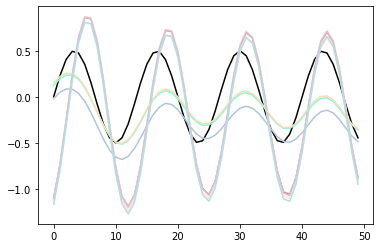

In [62]:
netD.eval()
netG.eval()


nn, dd = getNoise(batch_size)
new_seq_len = seq_len
for ns in range(new_seq_len):
  for b in range(batch_size):
    for s in range(seq_len-1):
      dd[b][0][s] = dd[b][0][s+1]
      nn[b][s][0] = dd[b][0][s+1]
  g = netG(nn)
  for b in range(batch_size):
    dd[b][0][-1] = g[b]

#n_graphs = 1
#for ng in range(n_graphs):
#  plt.plot(dd[n_graphs][0].detach().cpu())
#  plt.show()

#D:[batch_size, in_channels, len] data vs. G:[batch_size, seq_len, input_size] noise
d = getData(1)
plt.plot(d[0][0].detach().cpu(), 'black') 
plt.plot(dd[0][0].detach().cpu() , 'bisque')
plt.plot(dd[1][0].detach().cpu() , 'aquamarine')
plt.plot(dd[2][0].detach().cpu() , 'lightsteelblue')
plt.plot(dd[3][0].detach().cpu() , 'lightcoral')
plt.plot(dd[4][0].detach().cpu() , 'cornsilk')
plt.plot(dd[5][0].detach().cpu() , 'thistle')
plt.plot(dd[6][0].detach().cpu() , 'peachpuff')
plt.plot(dd[7][0].detach().cpu() , 'powderblue')
plt.show()



In [ ]:


n , d = getNoise(1)

d = d.squeeze(2)
d = d.unsqueeze(0)

print(f'target: {d[0][-1]}')
print(f'label real: {netD(d)}')


print(f'G output: {netG(n)}')
d[-1] = netG(n)
print(f'label fake: {netD(d)}')

In [26]:
netD.eval()
netG.eval()
test = getData(1)

test = test.squeeze(2)
test = test.unsqueeze(0)

testR = test
print(f'testR {testR}')

lR = netD(test)

print(f'lR {lR}')

testF = test

print(test.shape)
cr = 2
for t in range(seq_len -1): 
  testF[0][0][t] = t
  cr = cr * cr
  cr = cr
plt.plot(testF[0][0].detach().cpu())
plt.show()


print(f'testF {testF}')


lF = netD(testF)
print(f'lF {lF}')

n , d = getNoise(1)
print(f'noise: {n}')
print(f'd: {d}')

f = netG(n)

print(f'fake: {f}')
plt.plot(fake[0][0].detach().cpu())
plt.show()


testR tensor([[[[ 0.3172,  0.7462,  0.9175,  0.7720,  0.3599, -0.1764, -0.6518,
           -0.9022, -0.8410, -0.4894,  0.0311,  0.5409,  0.8640,  0.8887,
            0.6065,  0.1150, -0.4163, -0.8038, -0.9138, -0.7082, -0.2581,
            0.2811,  0.7233,  0.9157,  0.7920,  0.3947, -0.1388, -0.6244,
           -0.8944, -0.8556, -0.5213, -0.0071,  0.5096,  0.8504,  0.8975,
            0.6347,  0.1527, -0.3819, -0.7847, -0.9166, -0.7319, -0.2945,
            0.2446,  0.6992,  0.9124,  0.8106,  0.4288, -0.1010, -0.5959,
           -0.8851]]]], device='cuda:0')


RuntimeError: ignored